In [182]:
import magic
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Matplotlib command for Jupyter notebooks only
%matplotlib inline

import graphtools
import ot
from scipy.spatial import distance_matrix
from sklearn.decomposition import PCA

In [2]:
bmmsc_data = scprep.io.load_csv('https://github.com/KrishnaswamyLab/PHATE/raw/master/data/BMMC_myeloid.csv.gz')
bmmsc_data.head()

bmmsc_data = scprep.filter.filter_library_size(bmmsc_data, cutoff=1000)
bmmsc_data.head()

bmmsc_data = scprep.filter.filter_rare_genes(bmmsc_data, min_cells=10)
bmmsc_data.head()

bmmsc_data = scprep.normalize.library_size_normalize(bmmsc_data)
bmmsc_data = scprep.transform.sqrt(bmmsc_data)
bmmsc_data.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010F05Rik;mKIAA1841;Kiaa1841,0610010K14Rik;Rnasek,...,mKIAA1632;5430411K18Rik,mKIAA1994;Tsc22d1,mSox5L;Sox5,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31106,0.0,0.000000,0.0000,1.575047,0.0,0.0,0.0000,0.000000,0.0,1.575047,...,0.0,0.000000,0.0,0.0,0.0,1.575047,1.575047,0.0,0.0,0.000000
W31107,0.0,1.136584,0.0000,1.607372,0.0,0.0,0.0000,0.000000,0.0,1.968621,...,0.0,1.607372,0.0,0.0,0.0,1.968621,1.136584,0.0,0.0,1.607372
W31108,0.0,1.189802,0.0000,1.189802,0.0,0.0,0.0000,0.000000,0.0,2.060797,...,0.0,0.000000,0.0,0.0,0.0,2.060797,1.189802,0.0,0.0,0.000000
W31109,0.0,0.000000,1.0744,0.000000,0.0,0.0,1.0744,1.860915,0.0,3.038861,...,0.0,2.402431,0.0,0.0,0.0,2.402431,0.000000,0.0,0.0,0.000000
W31110,0.0,2.058031,0.0000,0.000000,0.0,0.0,0.0000,2.058031,0.0,2.058031,...,0.0,0.000000,0.0,0.0,0.0,3.564615,0.000000,0.0,0.0,2.058031


In [3]:
def impute(X, P, t):
    return np.array(np.linalg.matrix_power(P, t).dot(X))

In [5]:
# X = np.array(bmmsc_data[['Mpo', 'Klf1', 'Ifitm1']])
X = np.array(bmmsc_data)

keys = bmmsc_data.keys()
Mpo = np.where(keys == 'Mpo')[0][0]
Klf1 = np.where(keys == 'Klf1')[0][0]
Ifitm1 = np.where(keys == 'Ifitm1')[0][0]

n, m = X.shape
print(n, m)

C = distance_matrix(X, X)
np.fill_diagonal(C, np.inf)

2416 10782


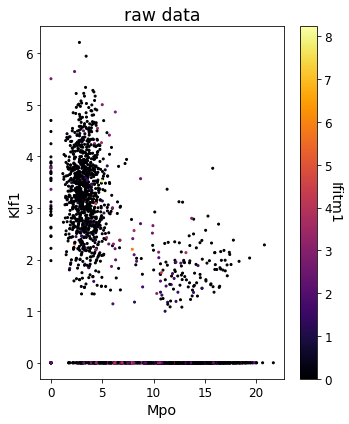

In [171]:
scprep.plot.scatter(x=X[:, Mpo], y=X[:, Klf1], c=X[:, Ifitm1], figsize=(5, 6),
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='raw data')
plt.savefig("../../figs/MAGICdata.jpg")

Calculating MAGIC...
  Running MAGIC on 2416 cells and 10782 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.41 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.54 seconds.
    Calculating affinities...
    Calculated affinities in 0.54 seconds.
  Calculated graph and diffusion operator in 5.54 seconds.
  Calculating imputation...
Calculated MAGIC in 5.66 seconds.


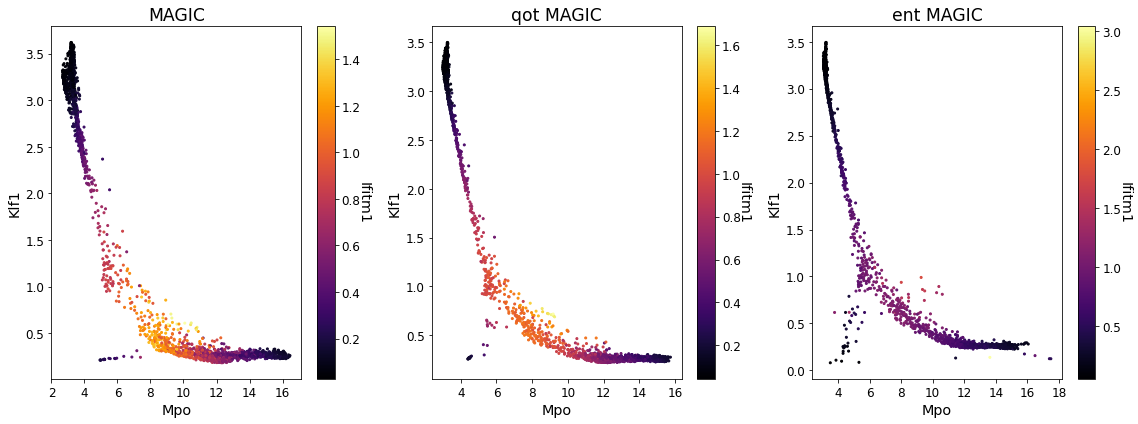

In [205]:
t = 5

magic_op_knn = magic.MAGIC()
magic_op_knn.set_params(t=t)
bmmsc_magic = magic_op_knn.fit_transform(bmmsc_data, genes=['Mpo', 'Klf1', 'Ifitm1'])

eps = 30
P_qot = ot.smooth.smooth_ot_dual(np.ones(n), np.ones(n), C, eps, reg_type='l2')

sigma = 0.5
P_ent = ot.sinkhorn(np.ones(n), np.ones(n), C, sigma)

X_qot = impute(X, P_qot, t)
X_ent = impute(X, P_ent, t)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 6))

scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], ax=ax1,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='MAGIC')

scprep.plot.scatter(x=X_qot[:, Mpo], y=X_qot[:, Klf1], c=X_qot[:, Ifitm1], ax=ax2,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='qot MAGIC')

scprep.plot.scatter(x=X_ent[:, Mpo], y=X_ent[:, Klf1], c=X_ent[:, Ifitm1], ax=ax3,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='ent MAGIC')

plt.tight_layout()
# plt.savefig("../../figs/eps=01_t=3.jpg")
plt.show()

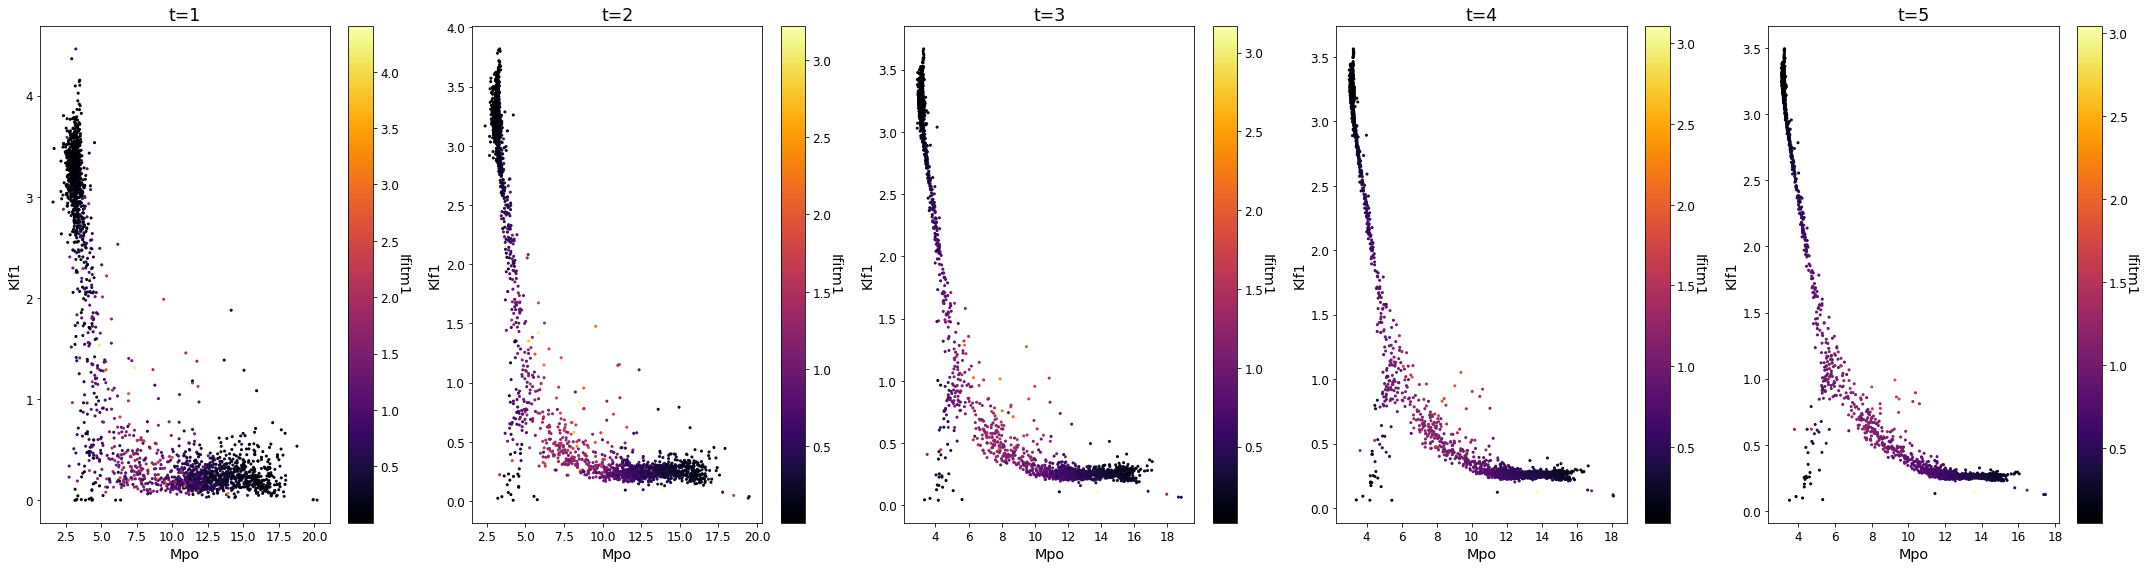

In [212]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(30, 8))
plt.title('ENT MAGIC')

X_ent = impute(X, P_ent, 1)
scprep.plot.scatter(x=X_ent[:, Mpo], y=X_ent[:, Klf1], c=X_ent[:, Ifitm1], ax=ax1,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=1')

X_ent = impute(X, P_ent, 2)
scprep.plot.scatter(x=X_ent[:, Mpo], y=X_ent[:, Klf1], c=X_ent[:, Ifitm1], ax=ax2,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=2')

X_ent = impute(X, P_ent, 3)
scprep.plot.scatter(x=X_ent[:, Mpo], y=X_ent[:, Klf1], c=X_ent[:, Ifitm1], ax=ax3,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=3')

X_ent = impute(X, P_ent, 4)
scprep.plot.scatter(x=X_ent[:, Mpo], y=X_ent[:, Klf1], c=X_ent[:, Ifitm1], ax=ax4,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=4')

X_ent = impute(X, P_ent, 5)
scprep.plot.scatter(x=X_ent[:, Mpo], y=X_ent[:, Klf1], c=X_ent[:, Ifitm1], ax=ax5,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=5')

plt.tight_layout()
plt.savefig("../../figs/ENT_MAGIC.jpg")

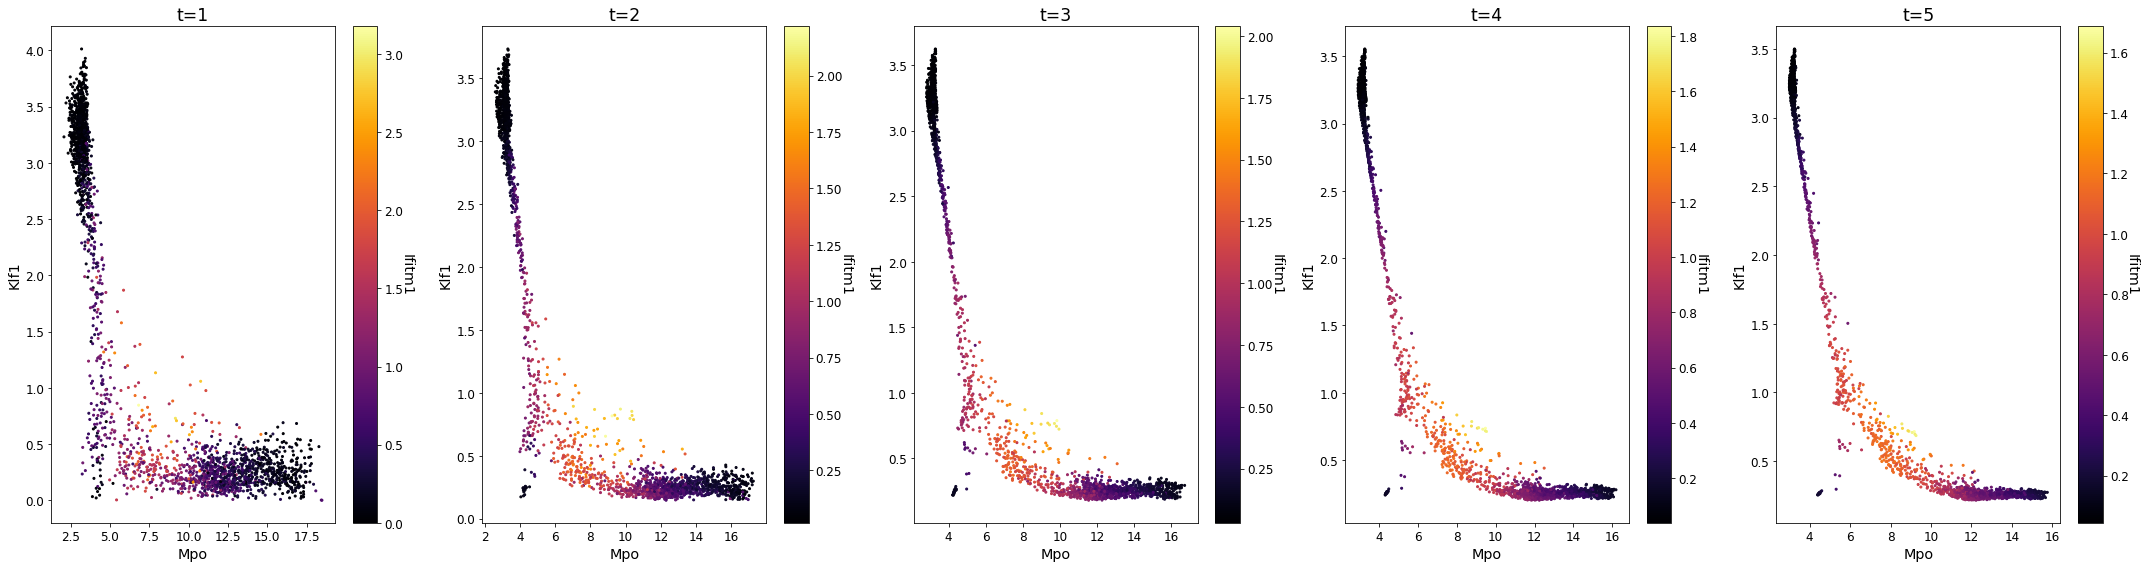

In [214]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(30, 8))
plt.title('QOT MAGIC')

X_qot = impute(X, P_qot, 1)
scprep.plot.scatter(x=X_qot[:, Mpo], y=X_qot[:, Klf1], c=X_qot[:, Ifitm1], ax=ax1,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=1')

X_qot = impute(X, P_qot, 2)
scprep.plot.scatter(x=X_qot[:, Mpo], y=X_qot[:, Klf1], c=X_qot[:, Ifitm1], ax=ax2,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=2')

X_qot = impute(X, P_qot, 3)
scprep.plot.scatter(x=X_qot[:, Mpo], y=X_qot[:, Klf1], c=X_qot[:, Ifitm1], ax=ax3,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=3')

X_qot = impute(X, P_qot, 4)
scprep.plot.scatter(x=X_qot[:, Mpo], y=X_qot[:, Klf1], c=X_qot[:, Ifitm1], ax=ax4,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=4')

X_qot = impute(X, P_qot, 5)
scprep.plot.scatter(x=X_qot[:, Mpo], y=X_qot[:, Klf1], c=X_qot[:, Ifitm1], ax=ax5,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=5')

plt.tight_layout()
plt.savefig("../../figs/QOT_MAGIC.jpg")

Calculating MAGIC...
  Running MAGIC on 2416 cells and 10782 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.34 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.56 seconds.
    Calculating affinities...
    Calculated affinities in 0.54 seconds.
  Calculated graph and diffusion operator in 5.48 seconds.
  Calculating imputation...
Calculated MAGIC in 5.60 seconds.
Calculating MAGIC...
  Running MAGIC on 2416 cells and 10782 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.25 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.56 seconds.
    Calculating affinities...
    Calculated affinities in 0.54 seconds.
  Calculated graph and diffusion operator in 5.42 seconds.
  Calculating imputation...
Calculated MAGIC in 5.54 seconds.
Calculating MAGIC...
  Running MAGIC on 2416 cells and 10782 genes.
  Calculating graph and diffusion operator...
    Ca

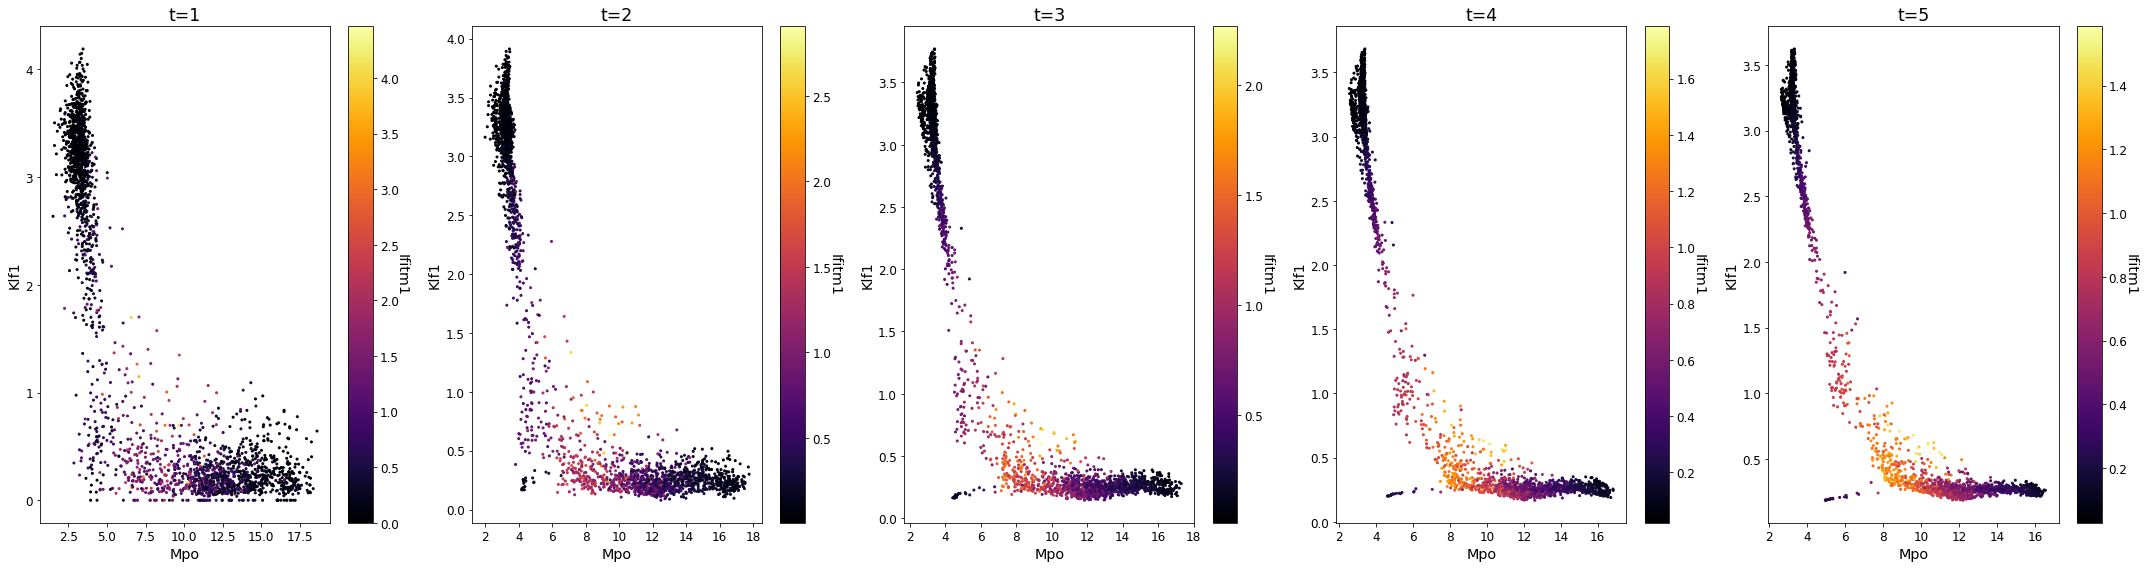

In [216]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(30, 8))
plt.title('ORG MAGIC')

magic_op_knn.set_params(t=1)
bmmsc_magic = magic_op_knn.fit_transform(bmmsc_data, genes=['Mpo', 'Klf1', 'Ifitm1'])
scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], ax=ax1,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=1')

magic_op_knn.set_params(t=2)
bmmsc_magic = magic_op_knn.fit_transform(bmmsc_data, genes=['Mpo', 'Klf1', 'Ifitm1'])
scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], ax=ax2,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=2')

magic_op_knn.set_params(t=3)
bmmsc_magic = magic_op_knn.fit_transform(bmmsc_data, genes=['Mpo', 'Klf1', 'Ifitm1'])
scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], ax=ax3,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=3')

magic_op_knn.set_params(t=4)
bmmsc_magic = magic_op_knn.fit_transform(bmmsc_data, genes=['Mpo', 'Klf1', 'Ifitm1'])
scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], ax=ax4,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=4')

magic_op_knn.set_params(t=5)
bmmsc_magic = magic_op_knn.fit_transform(bmmsc_data, genes=['Mpo', 'Klf1', 'Ifitm1'])
scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], ax=ax5,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t=5')

plt.tight_layout()
plt.savefig("../../figs/ORG_MAGIC.jpg")

Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...
Calculating imputation...


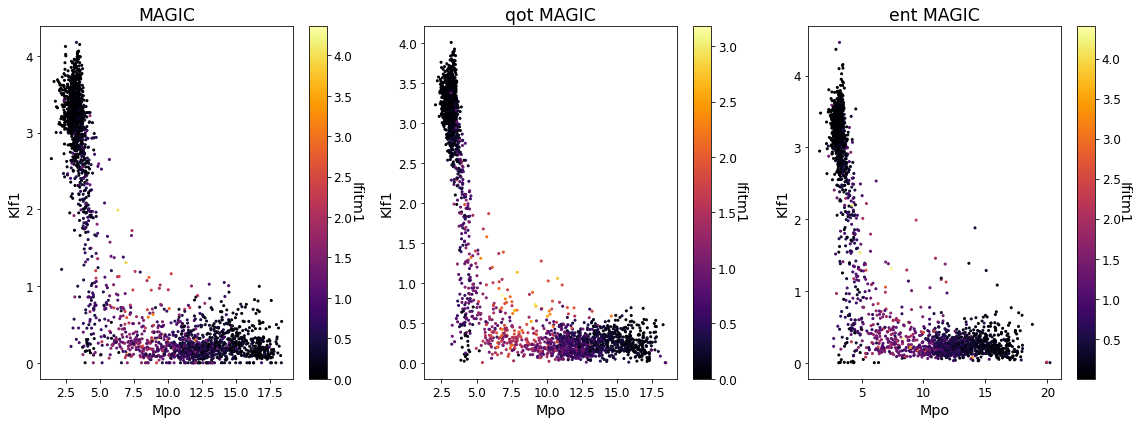

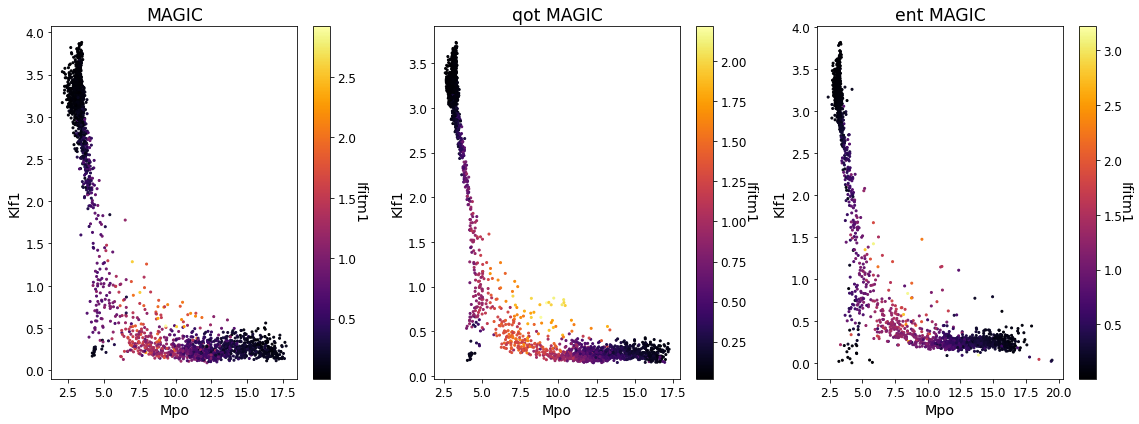

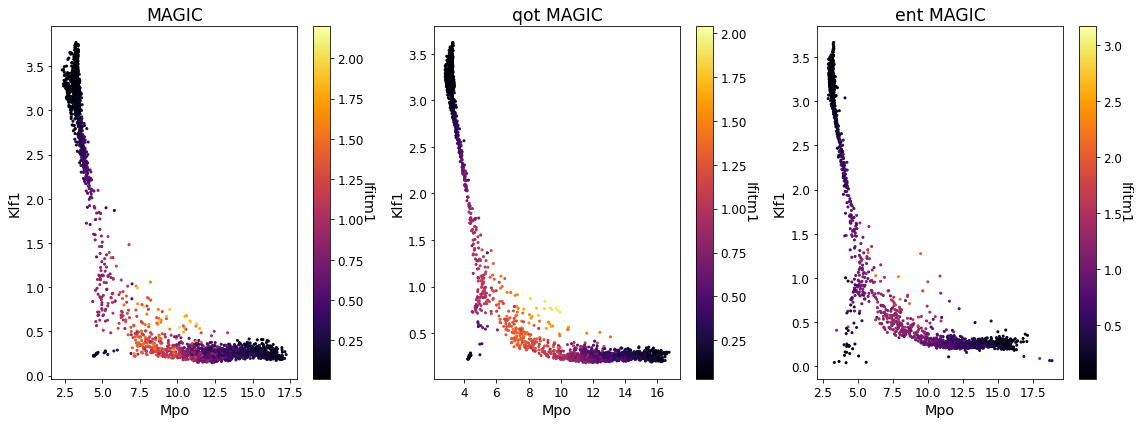

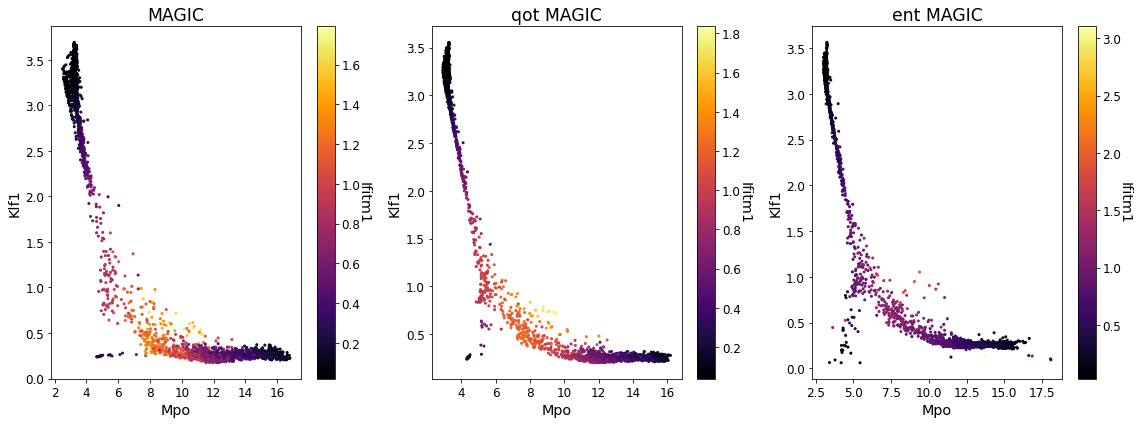

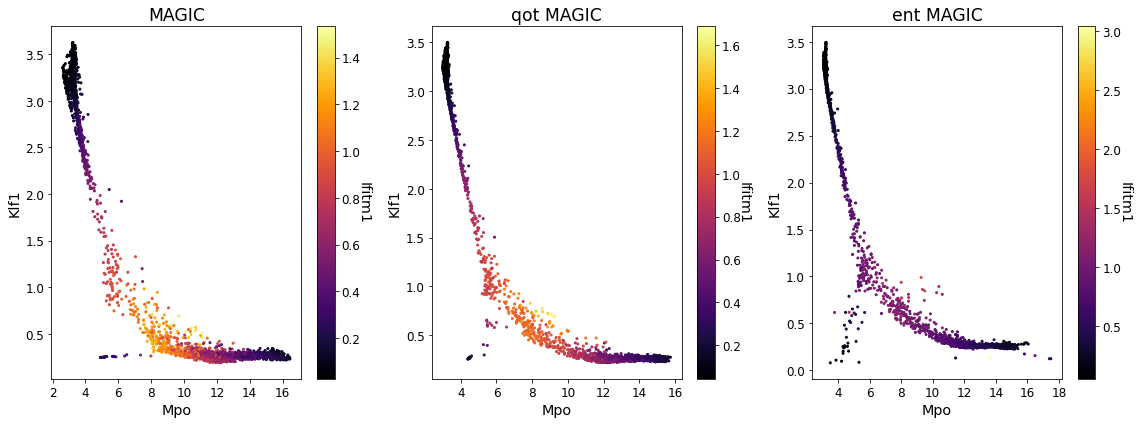

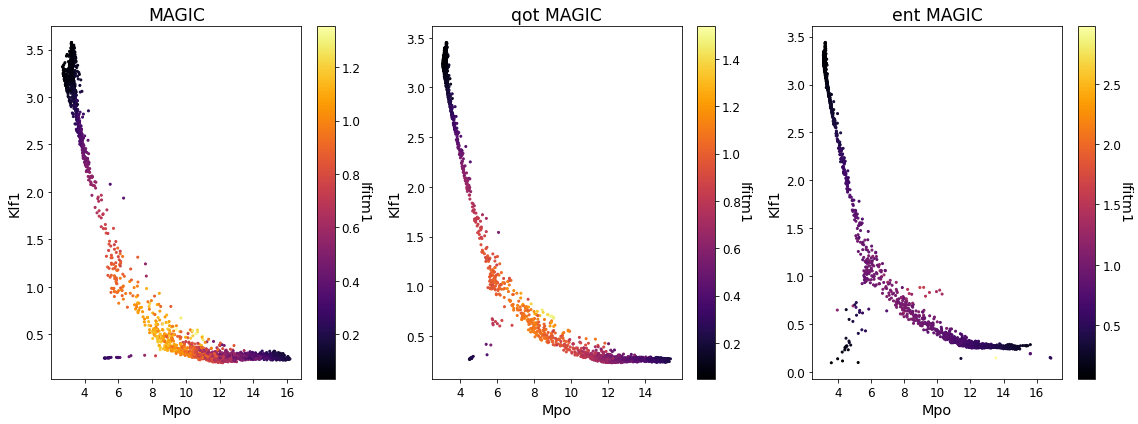

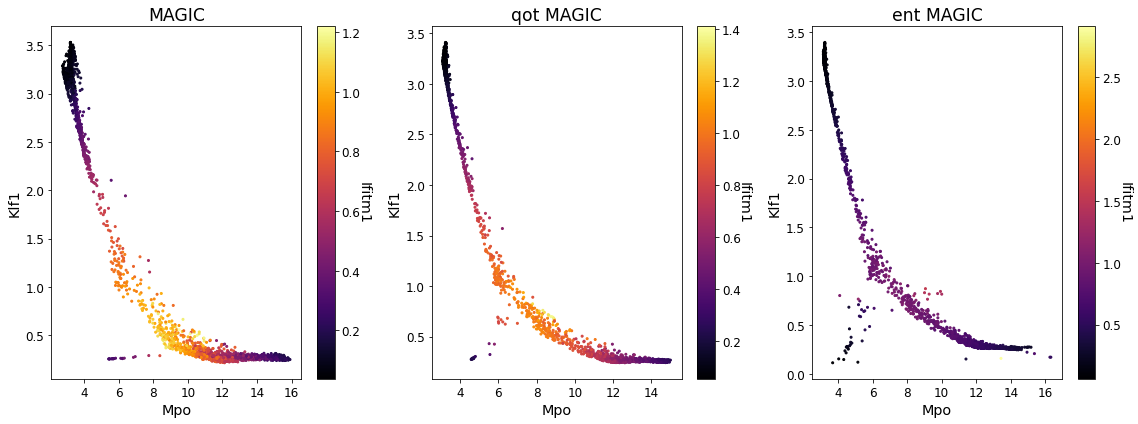

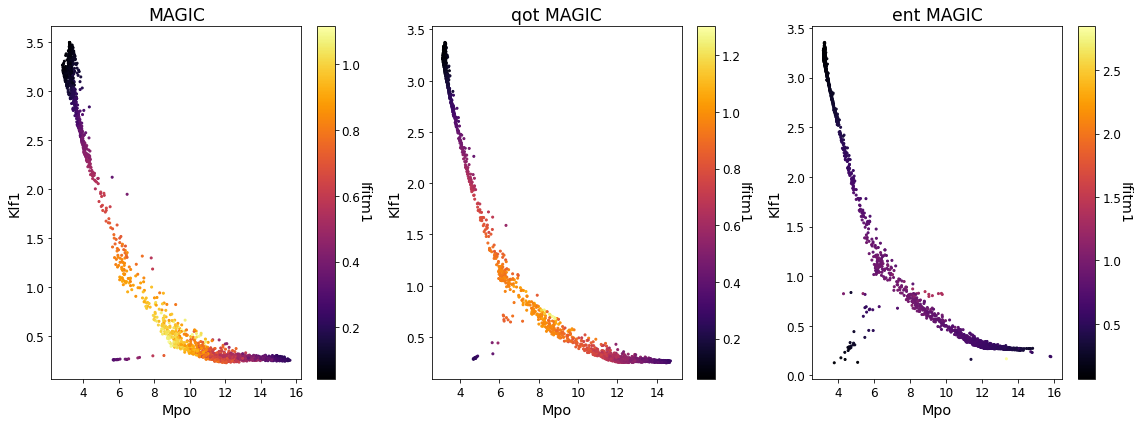

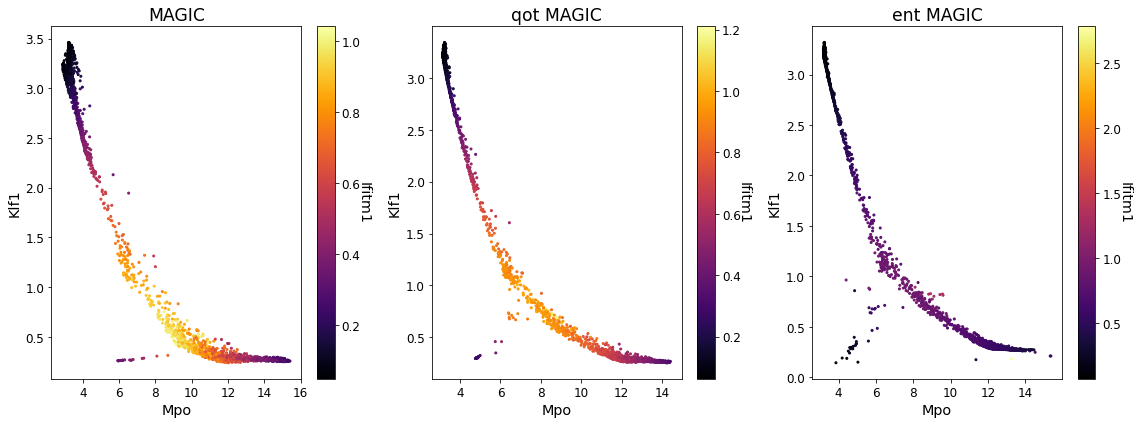

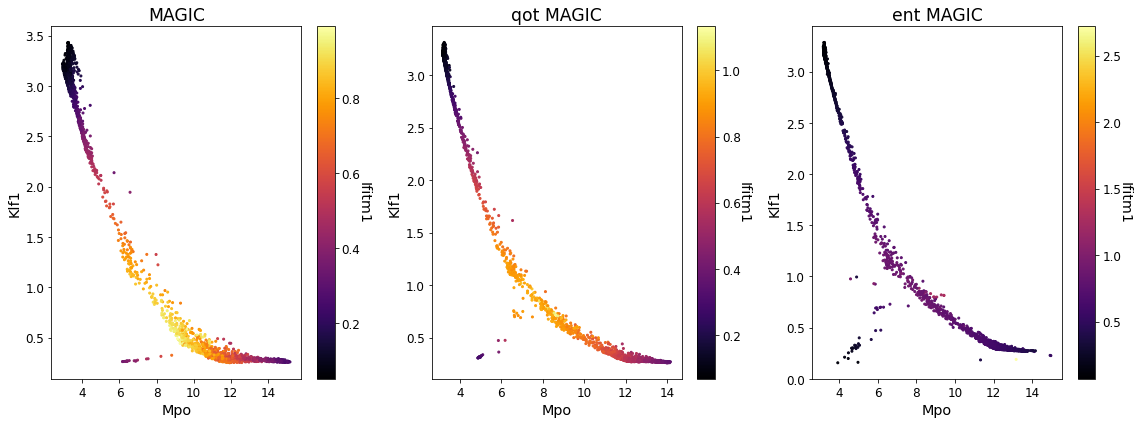

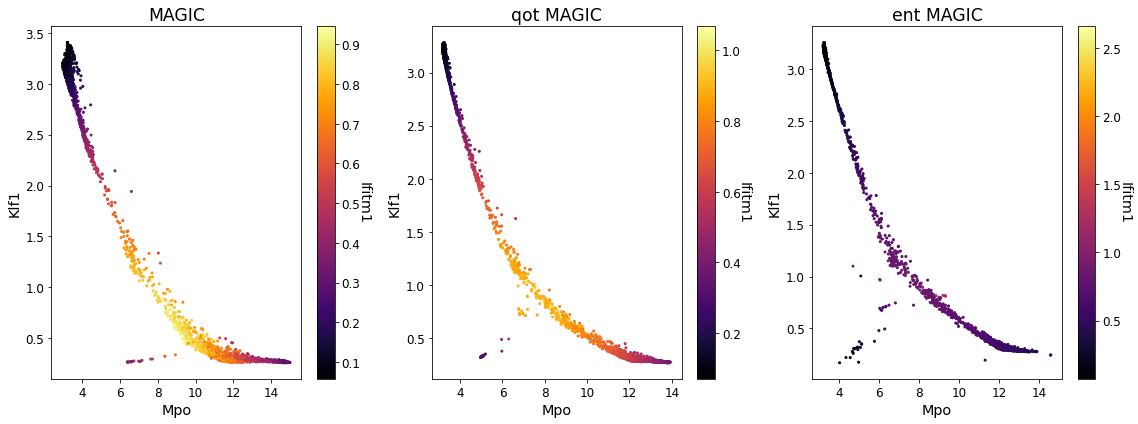

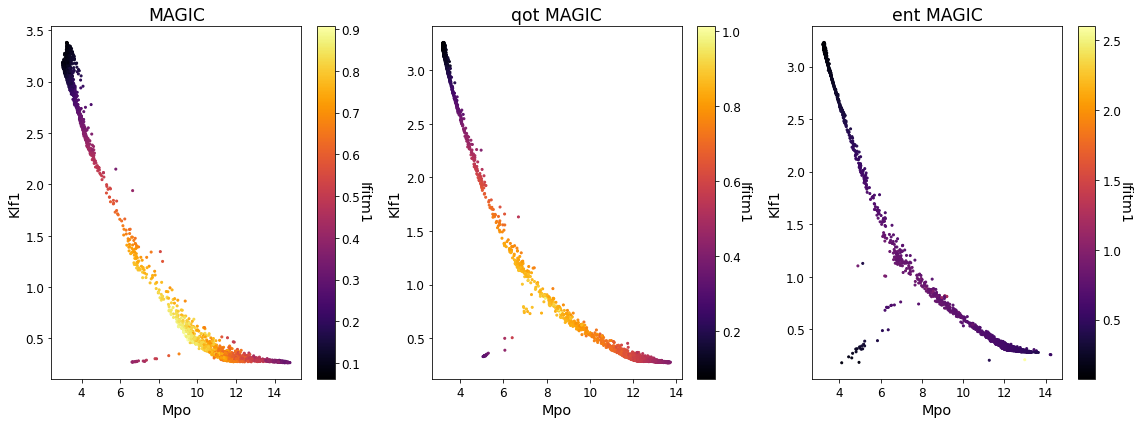

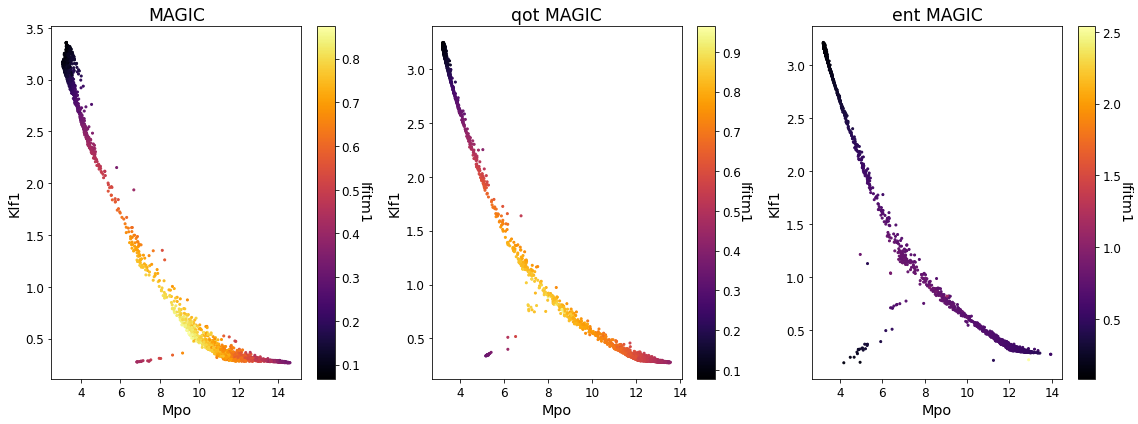

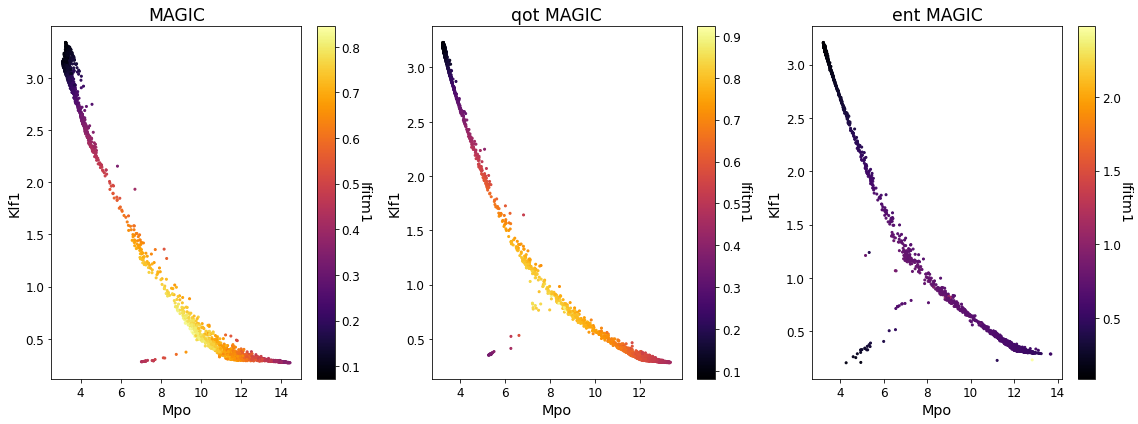

In [67]:

from PIL import Image, ImageDraw

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


images = []


fig = fig.get_figure()
# images.append(fig2img(fig))

max_t = 15
step = 1
  
for t in range(1, max_t, step):
    magic_op_knn.set_params(t=t)
    bmmsc_magic = magic_op_knn.transform(genes=["Mpo", "Klf1", "Ifitm1"])
    bmmsc_magic.head()

    X_qot = impute(X, P_qot, t)
    X_ent = impute(X, P_ent, t)

#     fig = scprep.plot.scatter(x=bmmsc_magic_qot['Mpo'], y=bmmsc_magic_qot['Klf1'], c=bmmsc_magic_qot['Ifitm1'], 
#                     xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='t='+str(i))
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 6))
    plt.title('t='+str(t))

    scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], ax=ax1,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='MAGIC')

    scprep.plot.scatter(x=X_qot[:, Mpo], y=X_qot[:, Klf1], c=X_qot[:, Ifitm1], ax=ax2,
                        xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='qot MAGIC')

    scprep.plot.scatter(x=X_ent[:, Mpo], y=X_ent[:, Klf1], c=X_ent[:, Ifitm1], ax=ax3,
                        xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='ent MAGIC')
    
    plt.tight_layout()
    fig = fig.get_figure()
    images.append(fig2img(fig))
  
images[0].save('../../figs/MAGIC.gif', save_all = True, append_images = images[1:], optimize = False, duration = 500)



0.27506263431428446


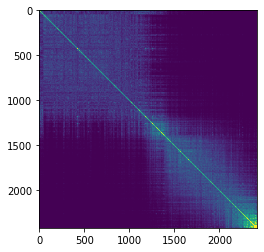

In [175]:
ind = np.argsort(X[:, Mpo])

t=2
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
Q_qot = np.linalg.matrix_power(P_qot, t)[ind, :][:, ind]
plt.imshow(Q_qot, vmax = np.quantile(Q_qot, 0.98))
print(np.sum(Q_qot > 0)/n**2)

1.0


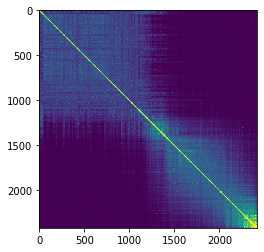

In [176]:
Q_ent = np.linalg.matrix_power(P_ent, t)[ind, :][:, ind]

plt.imshow(Q_ent, vmax = np.quantile(Q_ent, 0.98))
print(np.sum(Q_ent > 0)/n**2)

0.12042200725845358


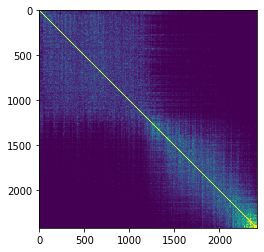

In [177]:
# Q = np.linalg.matrix_power(scprep.utils.toarray(magic_op_ent.diff_op), 100)
P_knn = scprep.utils.toarray(magic_op_knn.diff_op)

Q_knn = np.linalg.matrix_power(P_knn, t)[ind, :][:, ind]

plt.imshow(Q_knn, vmax = np.quantile(Q_knn, 0.98))
print(np.sum(Q_knn > 0)/n**2)
# P_knn